In [1]:
import nibabel as nib
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
import nilearn.image
import sklearn.decomposition
from sklearn.linear_model import Ridge
#from fMRI_Regions import atlas
from fMRI_Regions import atlas_masker
import sklearn.metrics as sm
from sampler import Sampler
from settings import settings
from scipy import signal
import scipy
import time
import mne
sampler = Sampler('/Users/ilamiheev/Desktop/data/')
num_frames = 143
num_train_frames = 100
num_test_frames = 20
bb=mne.io.read_raw_eeglab('/Users/ilamiheev/Downloads/CWL_Data/eeg/in-scan/trio1_mrcorrected_eoec_in-scan_hpump-off.set')
k=mne.events_from_annotations(bb)
a,b=np.where(k[0]==5)
delay=k[0][a[0],0]
fmri_end=k[0][a[-1],0]
train_start = settings.frame_creation_time * 5 + delay
train_end = settings.frame_creation_time * (num_train_frames)+train_start
test_start = settings.frame_creation_time * (num_frames - num_test_frames)+delay
test_end = settings.frame_creation_time * (num_frames)+ delay
patient_list = sampler.patient_list
current_patient = 35
random_state = 42

/Users/ilamiheev/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
<ipython-input-1-7e8b0e4bd52d>:21: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['EOG', 'ECG', 'CW1', 'CW2', 'CW3', 'CW4', 'CW5', 'CW6']. Their position has been left untouched.
  bb=mne.io.read_raw_eeglab('/Users/ilamiheev/Downloads/CWL_Data/eeg/in-scan/trio1_mrcorrected_eoec_in-scan_hpump-off.set')
<ipython-input-1-7e8b0e4bd52d>:21: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  bb=mne.io.read_raw_eeglab('/Users/ilamiheev/Downloads/CWL_Data/eeg/in-scan/trio1_mrcorrected_eoec_in-scan_hpump-off.set')


Used Annotations descriptions: ['boundary', '[]', 'R', 'Sync On', 'mri', 'S201', 'beo', 'S  1', 'eeo', 'fl', 'S241', 'S  5', 'R255', 'R254', 'S221', 'bec', 'eec']


<ipython-input-1-7e8b0e4bd52d>:21: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  bb=mne.io.read_raw_eeglab('/Users/ilamiheev/Downloads/CWL_Data/eeg/in-scan/trio1_mrcorrected_eoec_in-scan_hpump-off.set')


In [2]:
x_train1, y_train, x_fl_train = sampler.create_one_man_dataset(patient=current_patient, start_time=train_start,
                                                                  end_time=train_end, delay=delay,fmri_end=fmri_end)

Extracting EDF parameters from /Users/ilamiheev/Downloads/edf_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Setting up band-pass filter from 5 - 60 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 15.0 Hz
Filter length of 1651 samples (1.651 sec) selected


/Users/ilamiheev/.local/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


In [4]:
x_test1, y_test, x_fl_test =  sampler.create_one_man_dataset(patient=current_patient, start_time=test_start,
                                                               end_time=test_end, delay=delay, fmri_end=fmri_end)

Extracting EDF parameters from /Users/ilamiheev/Downloads/edf_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Setting up band-pass filter from 5 - 60 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 15.0 Hz
Filter length of 1651 samples (1.651 sec) selected


/Users/ilamiheev/.local/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


In [26]:
np.shape(y_train)

(1787, 21)

In [5]:
from scipy import signal
import mne
masker, labels = atlas_masker('sub')
eeg = mne.io.read_raw_edf('/Users/ilamiheev/Downloads/edf_1.edf',exclude=['EOG', 'ECG','CW1', 'CW2','CW3','CW4','CW5','CW6','Status'])
data = eeg.get_data()
channels=eeg.ch_names
eeg1=data
f, t, ft = signal.stft(eeg1[:,0:15000],fs=1000, nperseg=400)
ix_chs = f[2:20] 

Extracting EDF parameters from /Users/ilamiheev/Downloads/edf_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [7]:
alphas = np.logspace(-3, 3, 7)
#coefs = np.zeros((zone, np.shape(x_train)[2],np.shape(x_train)[3]))
scores= np.zeros(((len(labels)-1),np.shape(x_test1)[1],len(alphas)))
scoresr2 = np.zeros(((len(labels)-1),np.shape(x_test1)[1],len(alphas)))
scoresmse = np.zeros(((len(labels)-1),np.shape(x_test1)[1],len(alphas)))                 
#models = np.zeros(((len(labels)-1),np.shape(x_test)[1],len(alphas)),dtype=('Ridge'))
mm=[]
bbb=[]
x_train=x_train1*1e+4
x_test=x_test1*1e+4
for zone in range(len(labels)-1):
    s=[]
    jj=[]
    for a in range((np.shape(x_test)[1])):
        t=[]
        nn=[]
        for ii, alpha in enumerate(alphas):   
            ridgereg = Ridge(alpha, normalize=False)
            ridgereg.fit(x_train[:,a,:,:].reshape(np.shape(x_train)[0],-1), y_train[:,zone]) 
            predicted_y_test = ridgereg.predict(x_test[:,a,:,:].reshape(np.shape(x_test)[0],-1))
            scores[zone,a,ii] = scipy.stats.pearsonr(y_test[:, zone], predicted_y_test)[0]
            scoresr2[zone,a,ii] = sklearn.metrics.r2_score(y_test[:, zone], predicted_y_test)
            scoresmse[zone,a,ii] = sklearn.metrics.mean_squared_error(y_test[:, zone], predicted_y_test)       
            t.append(ridgereg)
            nn.append(predicted_y_test)
        s.append(t)
        jj.append(nn)
    mm.append(s)
    bbb.append(jj)
mmm=np.array(mm)
bbb=np.array(bbb)

In [33]:
coefs=[]
scores_max1=[]
scores_max2=[]
scores_max3=[]
mmm=np.array(mmm)

#mmm1= np.delete(mmm, (0,1,28,29,60), axis=1)
#scoresmse1=np.delete(scoresmse, (0,1,28,29,60), axis=1)
#mmm2= np.delete(mmm1, (28), axis=1)
#scoresmse2=np.delete(scoresmse1, (28), axis=1)
#scores1=np.delete(scores, (0,1,28,29,60), axis=1)
R=[]
for zone in range(len(labels)-1):
    #sigm=[]
    #kkk=[]
    #for i in range(len(channels)):
    ind = np.unravel_index((np.argmin((scoresmse[zone,...]))), scoresr2[zone,...].shape)
    #ind=np.argmax(np.abs(scores[zone,i,...]))
    #kkk.append(mmm[zone,i,ind].coef_)
    coefs.append(mmm[zone,ind[0], ind[1]].coef_)
    #sigm.append(scores[zone,i,ind])
    scores_max1.append(scores[zone,ind[0],ind[1]])
    scores_max2.append(scoresmse[zone,ind[0],ind[1]])
    scores_max3.append(scoresr2[zone,ind[0],ind[1]])
    R.append(ind)
    #scores_max.append(sigm)
    #coefs.append(kkk)
coefs=np.array(coefs)
#scores_max=np.array(scores_max)

In [23]:
coefs

array([[ 0.30656637,  0.2623626 ,  0.40210433, ..., -2.60616949,
        -2.36228186, -2.4294271 ],
       [ 0.39740626,  0.6797841 ,  0.54833195, ..., -1.47038652,
        -1.46143169, -1.89871619],
       [-0.53274431, -1.05515381, -0.78492741, ..., -0.27449488,
        -0.26591249, -0.29331504],
       ...,
       [ 0.01012763, -0.06411184,  0.21639145, ..., -2.37113366,
        -2.14353281, -2.46513817],
       [-2.045566  , -1.67067128, -1.59003318, ..., -5.07677132,
        -5.8303354 , -7.17373365],
       [ 0.36639371,  0.19239029,  0.05257091, ...,  2.01002169,
         2.10288511,  2.10136662]])

In [34]:
scores_max1

[0.9520674618829121,
 0.9329436024536222,
 0.5822443398313961,
 0.9034162006501206,
 0.8839510147387173,
 0.7883828504997341,
 0.8567726712283602,
 0.8958952327759954,
 0.7463191716418279,
 0.8947562530506026,
 0.7615215936093558,
 0.9319581284641024,
 0.892673843610974,
 0.6548075842954786,
 0.9001615019802733,
 0.9227659908396815,
 0.90059692358094,
 0.7334270922111361,
 0.8740924686144499,
 0.4759754537573616,
 0.8279279089555641]

In [35]:
scores_max2

[0.17472185529278703,
 0.03890262333980356,
 0.5987042696991999,
 0.17486434440885368,
 0.1521401702367141,
 0.3225785255707333,
 0.2613356809851962,
 0.2673286524543108,
 0.3578104349671278,
 0.12056879322331059,
 0.4070662410669872,
 0.15312040021945822,
 0.16734331289325527,
 0.3529894293863848,
 0.23096801204479603,
 0.1827811705739848,
 0.08947171604527732,
 0.35888693278801426,
 0.3587780133832256,
 0.6018765582279282,
 0.3641115528759498]

In [36]:
scores_max3

[0.6494129847371165,
 0.8681476626081864,
 0.3144450412165155,
 0.7811488969010543,
 0.6419840964533765,
 0.35826389056563823,
 0.5966923918594871,
 0.6906058890917282,
 0.15941403131894472,
 0.7971326190224793,
 0.5153100848236802,
 0.8464058001388355,
 0.7513272579813072,
 0.36338633804654286,
 0.7356108406724902,
 0.8281545621196401,
 0.8107520836075438,
 0.25394937581345256,
 0.4225989869645148,
 -0.9001878929974683,
 0.6283820642817219]

Text(0, 0.5, 'R')

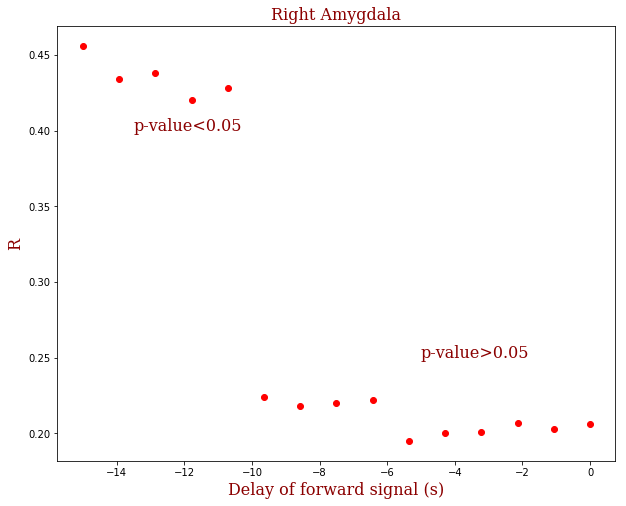

In [37]:
MM=[0.456,0.434,0.438,0.420,0.428,0.224,0.218,0.220,0.222,0.195,0.200,0.201,0.207,0.203,0.206]
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(np.linspace(-15, 0, num=15),MM,'ro')
plt.text(-13.5, 0.4, 'p-value<0.05',fontdict=font)
plt.text(-5, 0.25, 'p-value>0.05',fontdict=font)
plt.title(labels[20], fontdict=font)
plt.xlabel(xlabel = 'Delay of forward signal (s)',fontdict=font)
plt.ylabel(ylabel='R',fontdict=font)

In [ ]:
mne.viz.plot_topomap(data, pos=eeg.info, vmin=None, vmax=None, cmap=None, sensors=True, res=64, names=channels, show_names=True)

In [ ]:
channels

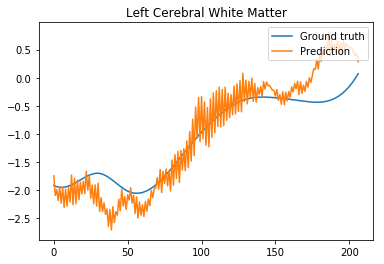

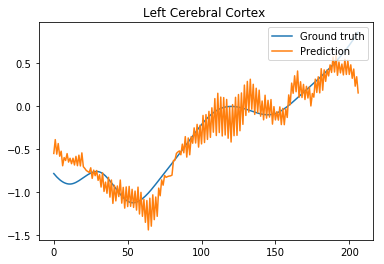

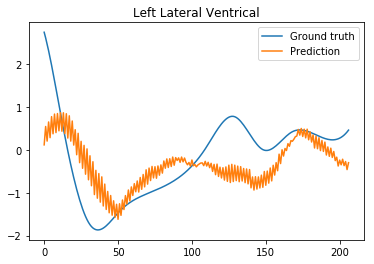

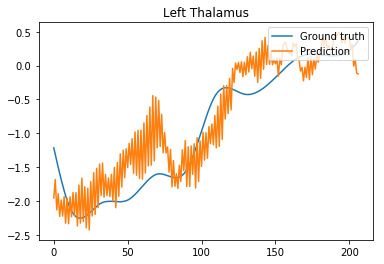

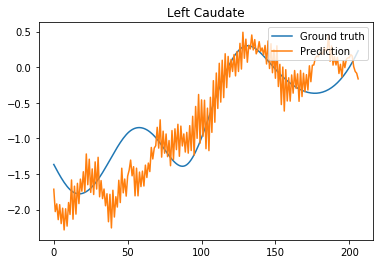

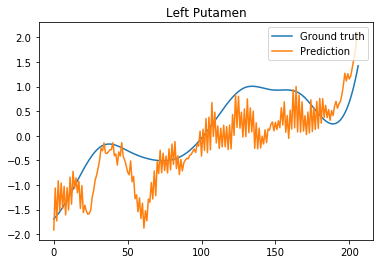

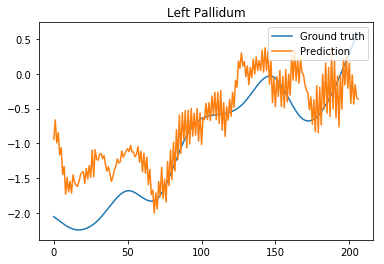

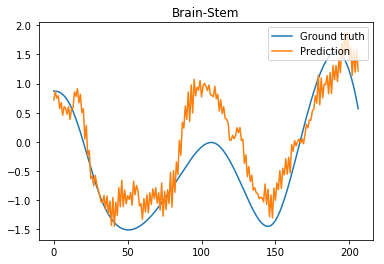

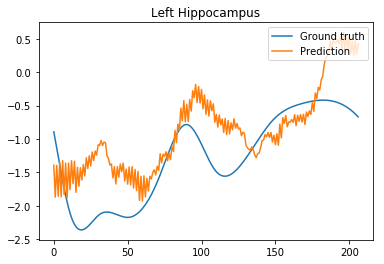

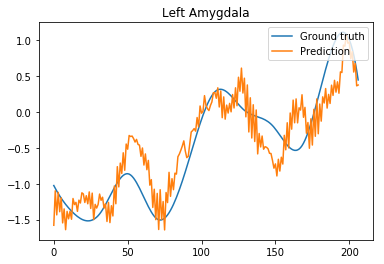

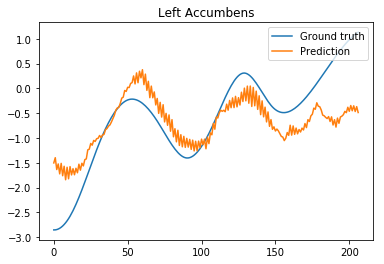

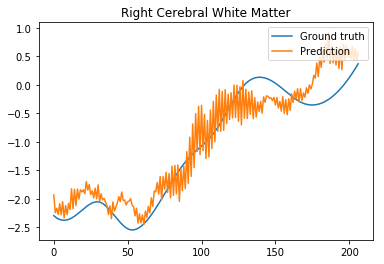

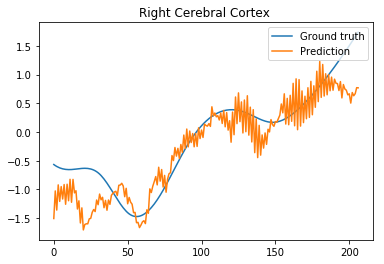

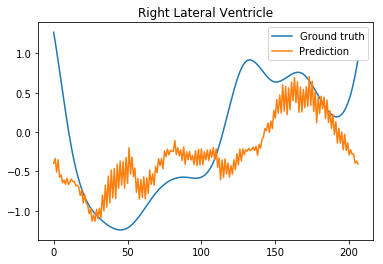

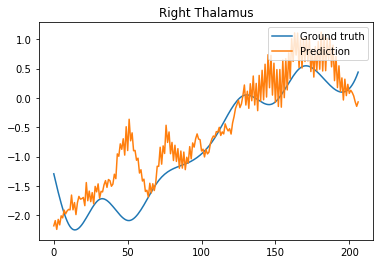

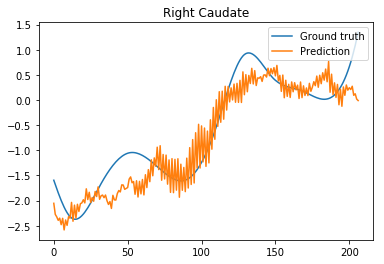

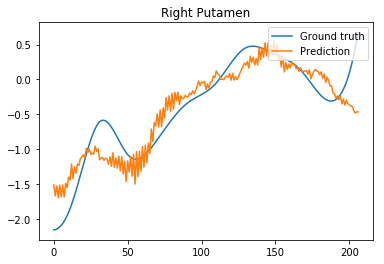

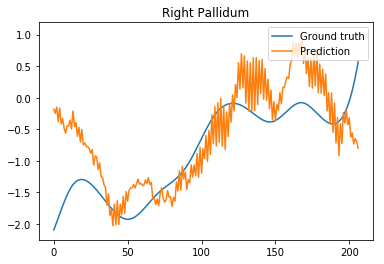

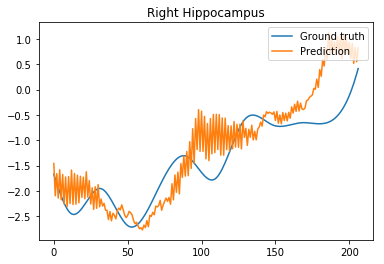

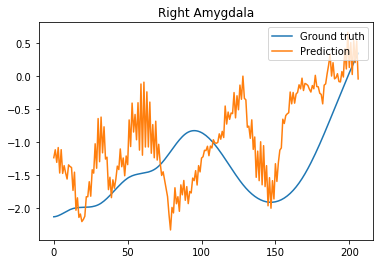

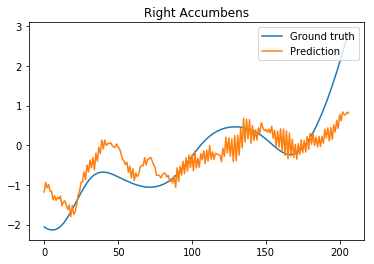

In [30]:
def norm(data):
    return (data)/(max(data)-min(data))
for i in range(len(labels)-1):
    lkl=bbb[i,R[i][0],R[i][1]]
    plt.plot(y_test[:,i])
    plt.plot(lkl)
    plt.legend(('Ground truth','Prediction'),
    loc='upper right')
    plt.title(labels[i+1])
    plt.show()

In [ ]:
labels[11]

/Users/ilamiheev/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


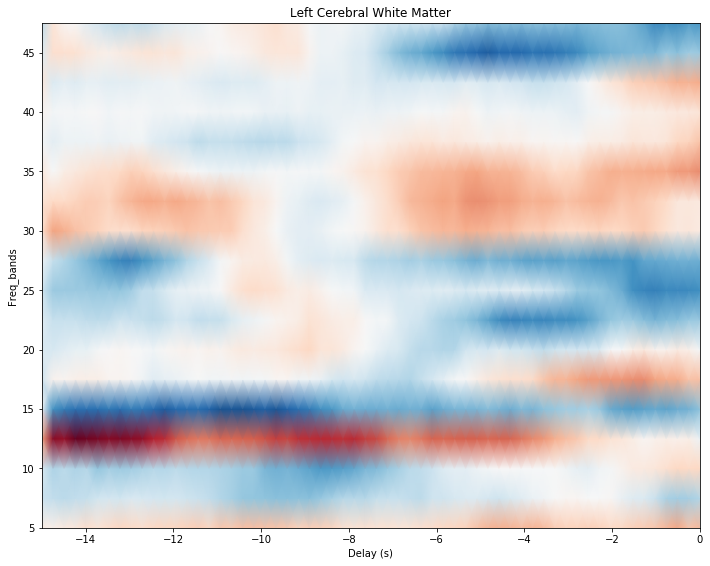

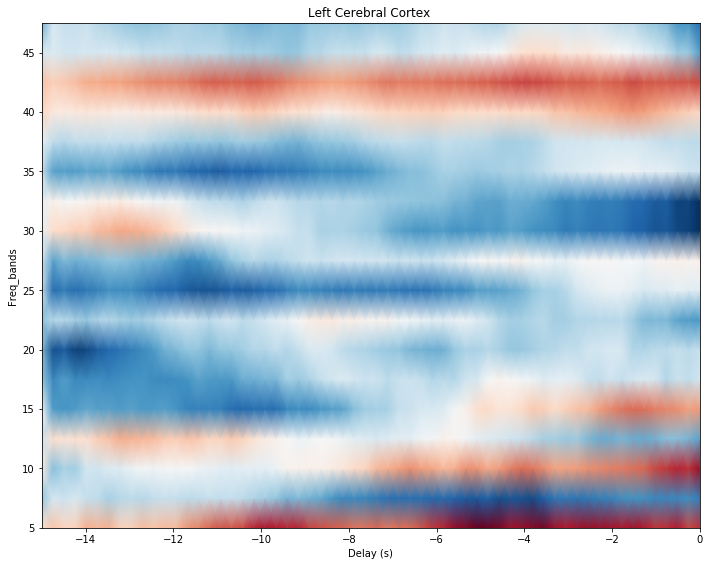

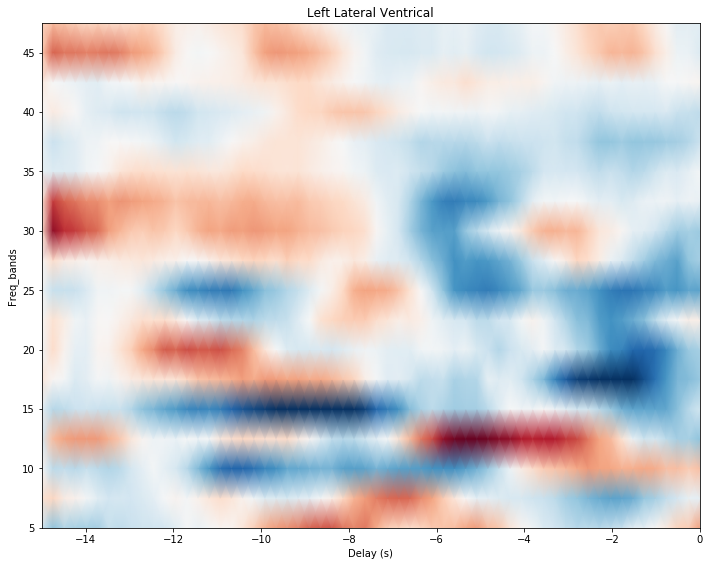

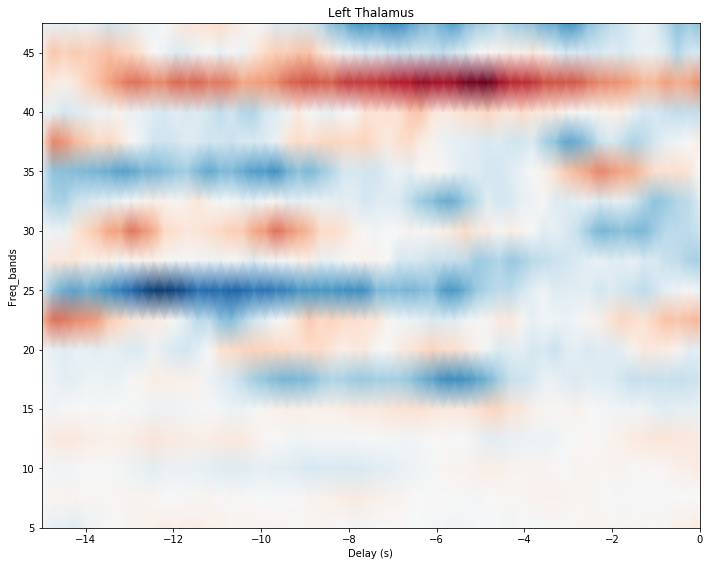

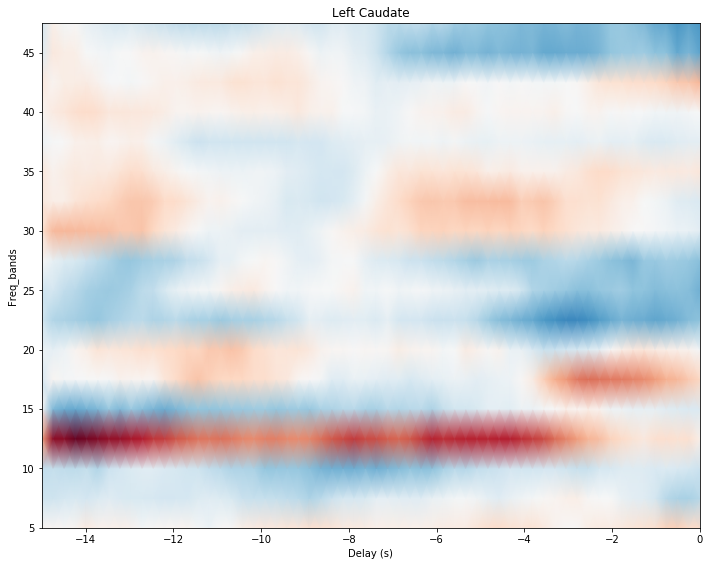

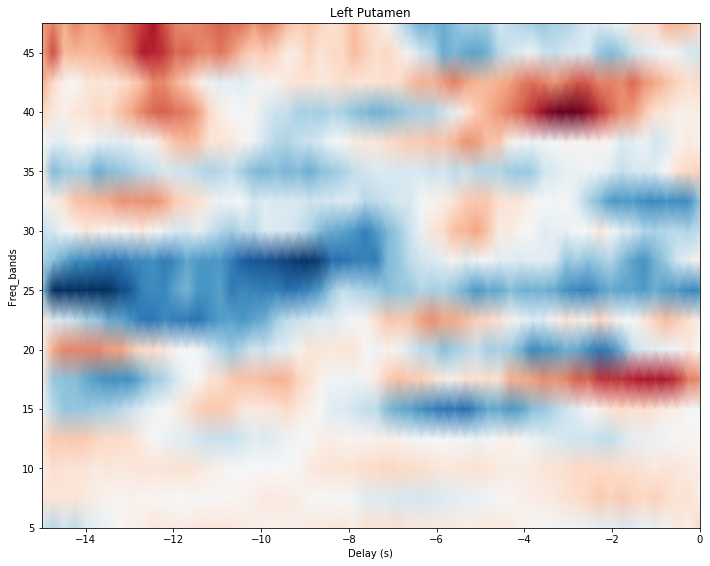

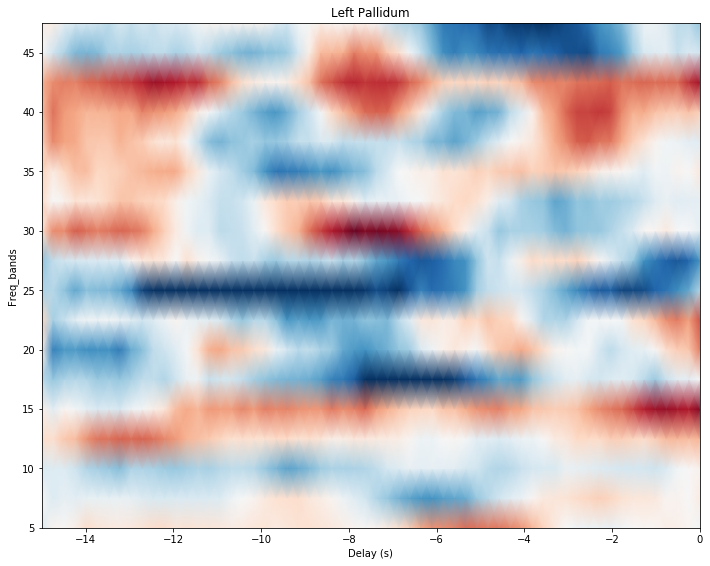

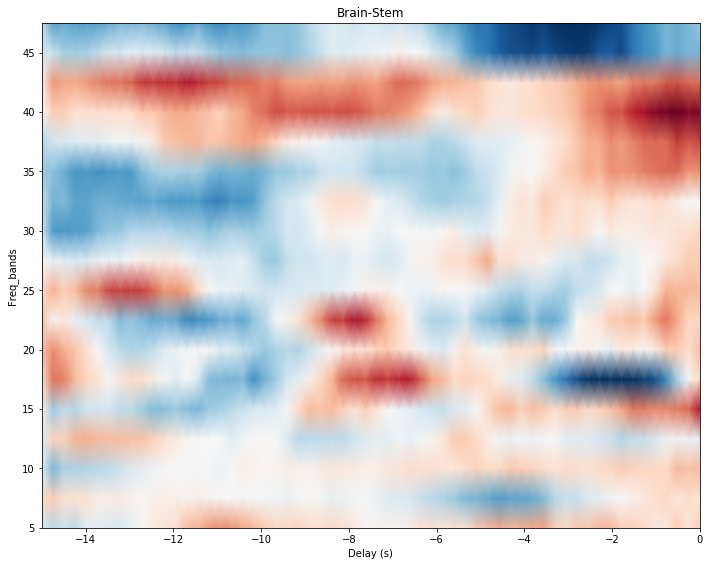

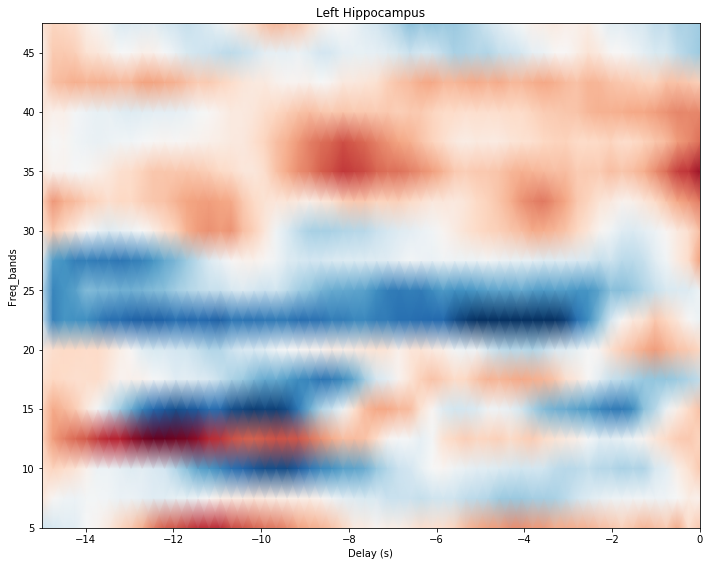

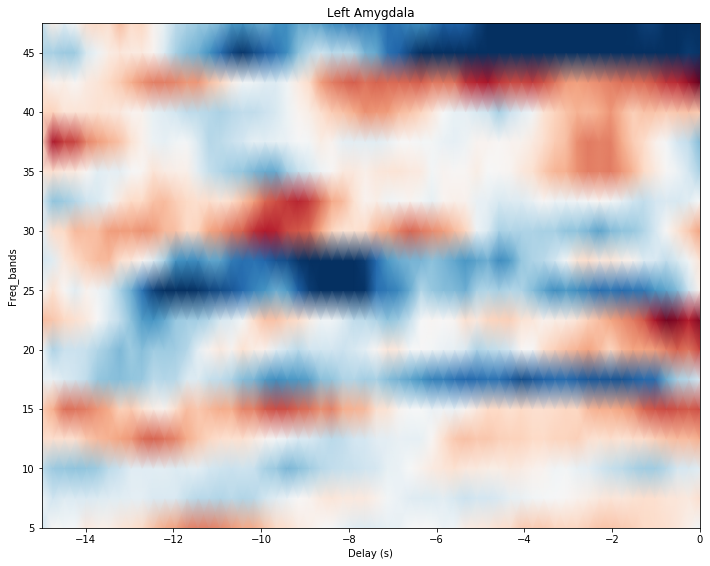

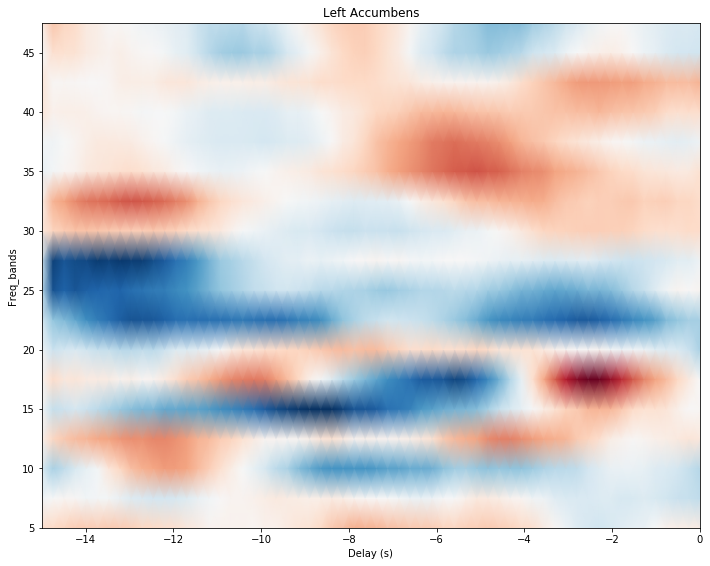

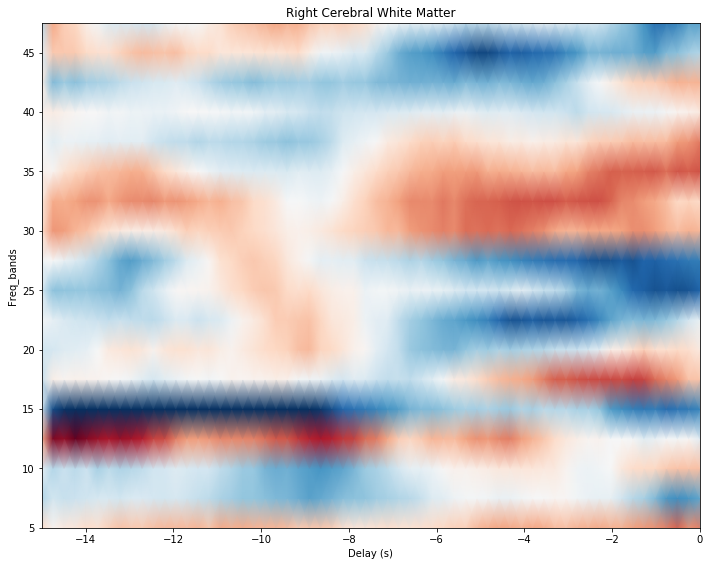

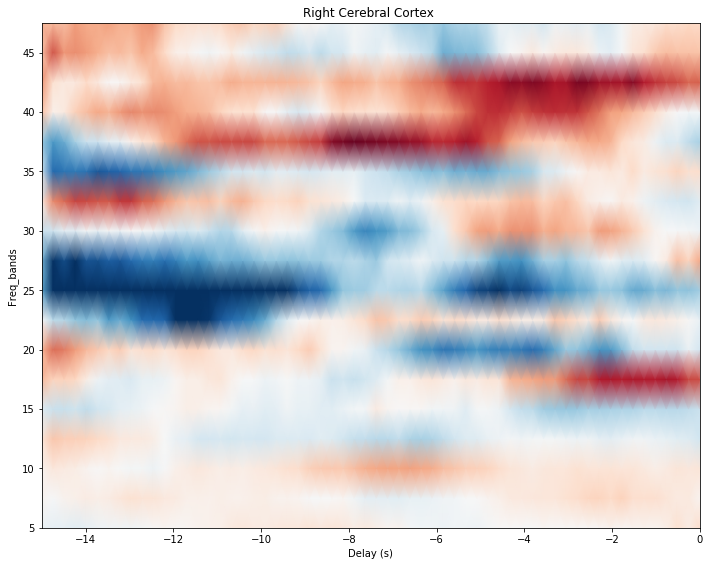

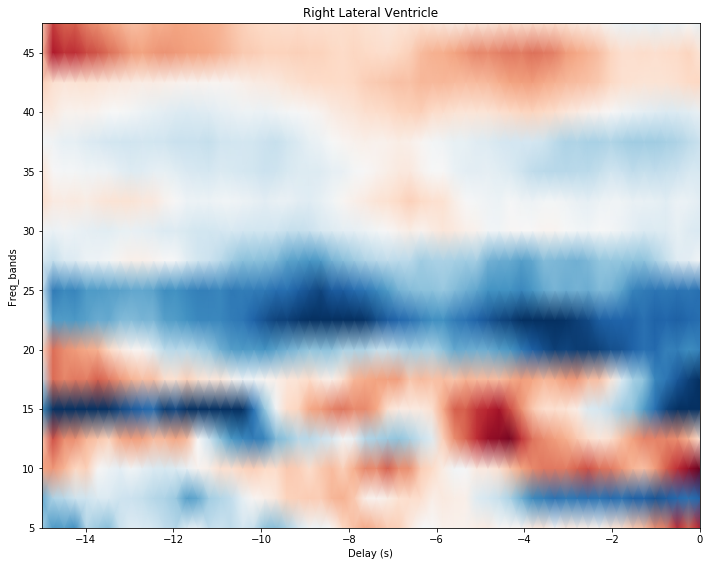

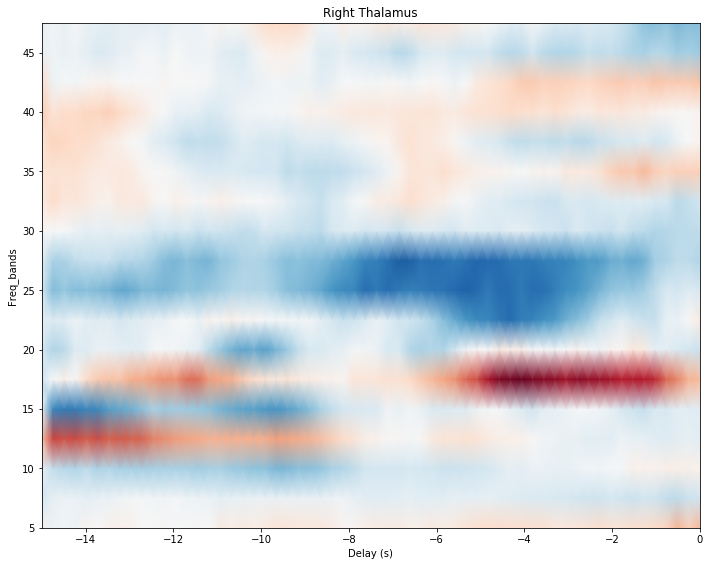

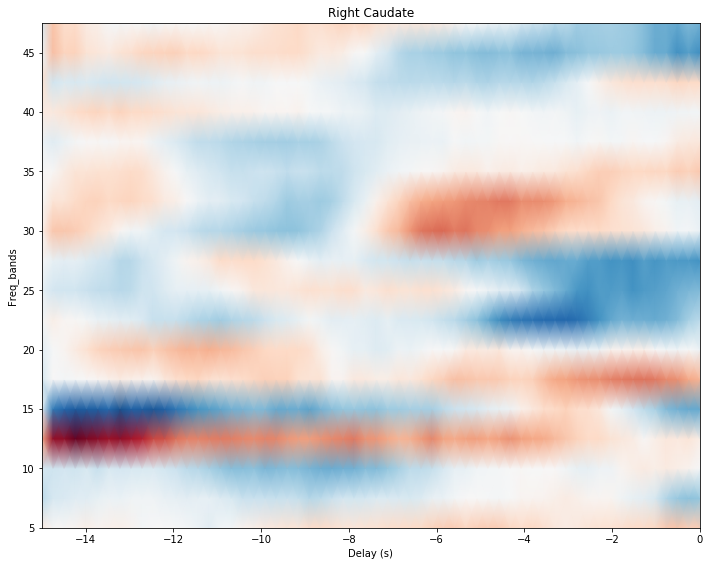

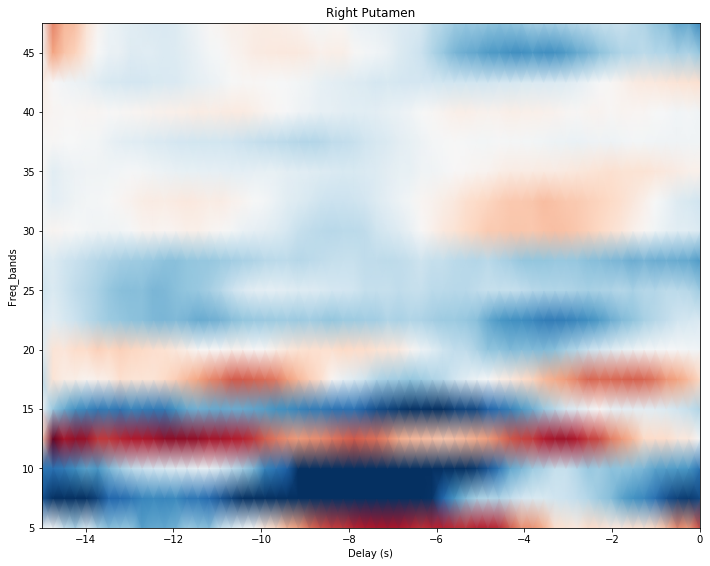

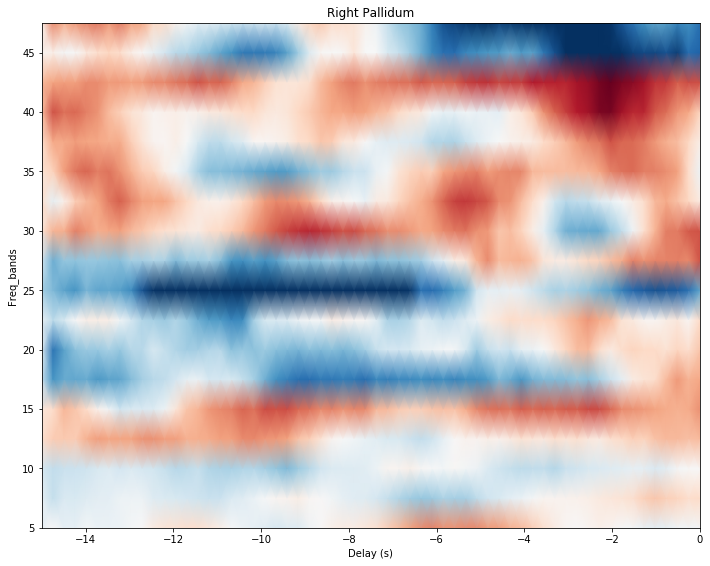

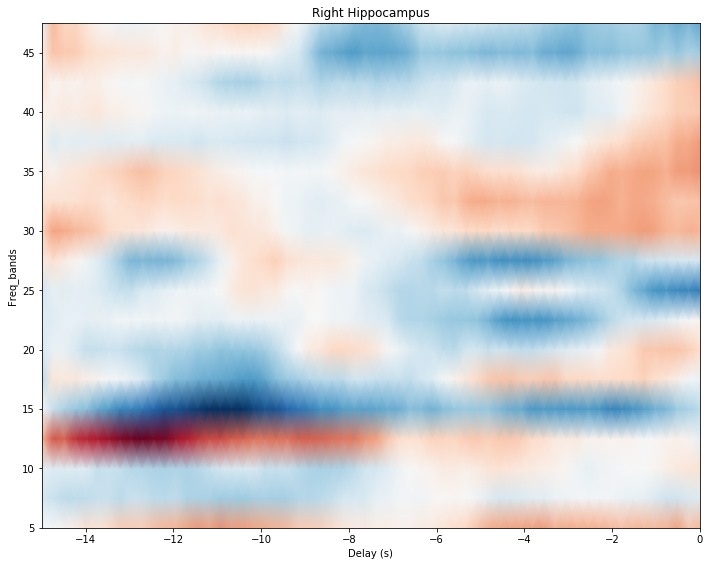

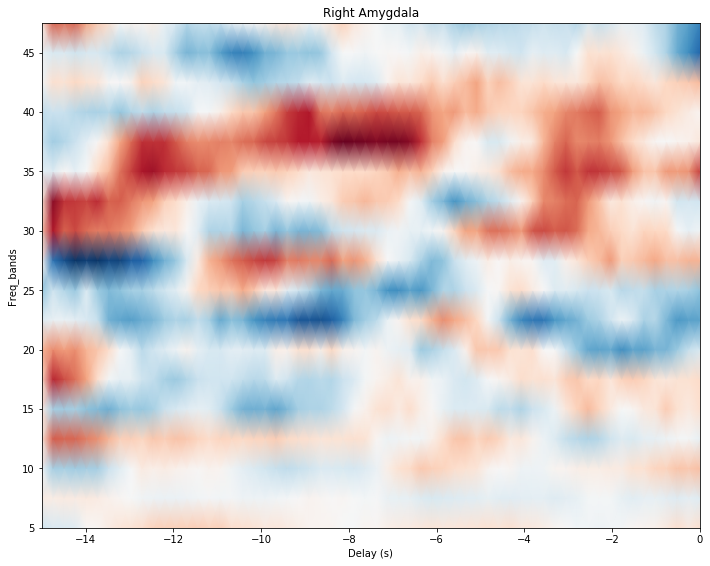

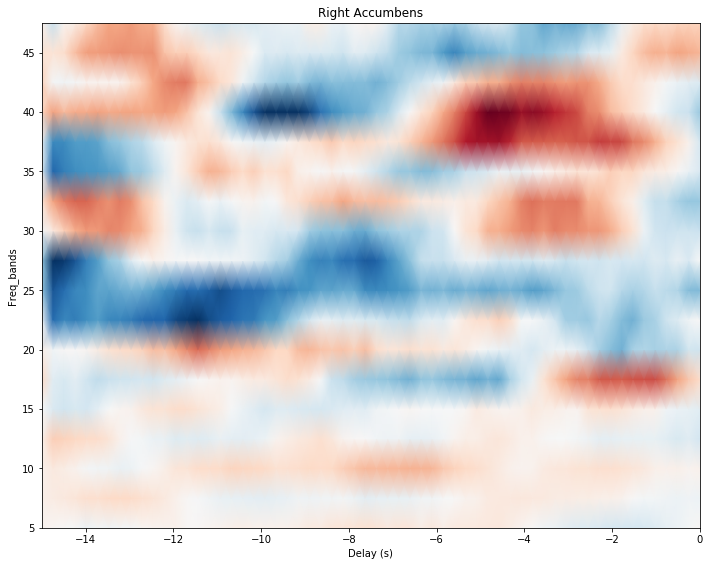

In [38]:
for i in range(len(labels)-1):
    coefs=np.array(coefs)
    mean_coefs=coefs[i,:]
    max_coef = mean_coefs.max()
    mean_coefs=mean_coefs.reshape(np.shape(x_test)[2],np.shape(x_test)[3])
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.pcolormesh(np.linspace(-15,0,60),  ix_chs, mean_coefs, cmap='RdBu_r',
                  vmin=-max_coef, vmax=max_coef, shading='gouraud')
    #ax.axvline(time_plot, ls='--', color='k', lw=2)
    ax.set(xlabel='Delay (s)', ylabel='Freq_bands', title=labels[i+1])
    #plt.setp(ax.get_xticklabels(), rotation=45)
    mne.viz.tight_layout()

In [ ]:
alphas = np.logspace(-3, 3, 7)
#coefs = np.zeros((zone, np.shape(x_train)[2],np.shape(x_train)[3]))
scoresfl= np.zeros(((len(labels)-1),np.shape(x_test)[1],len(alphas)))
scoresr2fl = np.zeros(((len(labels)-1),np.shape(x_test)[1],len(alphas)))
scoresmsefl = np.zeros(((len(labels)-1),np.shape(x_test)[1],len(alphas)))                 
#models = np.zeros(((len(labels)-1),np.shape(x_test)[1],len(alphas)),dtype=('Ridge'))
mmfl=[]
bbbfl=[]
for zone in range(len(labels)-1):
    s=[]
    jj=[]
    for a in range((np.shape(x_test)[1])):
        t=[]
        nn=[]
        for ii, alpha in enumerate(alphas):   
            ridgereg = Ridge(alpha, normalize=True)
            ridgereg.fit(x_train[:,a,:,:].reshape(np.shape(x_fl_train)[0],-1), y_train[:,zone])
            predicted_y_testfl = ridgereg.predict(x_fl_test[:,a,:,:].reshape(np.shape(x_fl_test)[0],-1))
            scoresfl[zone,a,ii] = scipy.stats.pearsonr(y_test[:, zone], predicted_y_testfl)[0]
            scoresr2fl[zone,a,ii] = sklearn.metrics.r2_score(y_test[:, zone], predicted_y_testfl)
            scoresmsefl[zone,a,ii] = sklearn.metrics.mean_squared_error(y_test[:, zone], predicted_y_testfl)       
            t.append(ridgereg)
            nn.append(predicted_y_testfl)
            #models[zone,a,ii] = ridgereg
        s.append(t)
        jj.append(nn)
    mmfl.append(s)
    bbbfl.append(jj)
mmmfl=np.array(mmfl)
bbbfl=np.array(bbbfl)

In [ ]:
coefsfl=[]
scores_maxfl=[]
mmmfl=np.array(mmmfl)
Rfl=[]
for zone in range(len(labels)-1):
    ind = np.unravel_index((np.argmin(scoresmsefl[zone,...])), scores[zone,...].shape)
    coefsfl.append(mmmfl[zone, ind[0], ind[1]].coef_)
    scores_maxfl.append(scoresmsefl[zone,ind[0],ind[1]])
    Rfl.append(ind)
coefsfl=np.array(coefs)
mean_coefsfl=coefsfl[1,:]
max_coeffl = mean_coefsfl.max()

In [ ]:
scores_maxfl

In [ ]:
pp=[]
for i in range(len(labels)-1):
      pp.append(scores_maxfl[i]-scores_max[i])

In [ ]:
pp

In [ ]:
for i in range(len(labels)-1):
    lklfl=bbbfl[i,Rfl[i][0],Rfl[i][1]]
    plt.plot(y_test[:,i])
    plt.plot(lklfl)
    plt.legend(('Ground truth','Prediction'),
    loc='upper right')
    plt.title(labels[i+1])
    plt.show()

In [ ]:
x_fl_train_new_list=[]
x_fl_test_new_list=[]
x_fl_train_1=np.roll(x_fl_train,100,axis=0)
x_fl_test_1=np.roll(x_fl_test,100,axis=0)
for zeta in range(100):
    x_train_fl_new=np.roll(x_fl_train_1,zeta*10,axis=0)
    x_test_fl_new=np.roll(x_fl_test_1,zeta*10,axis=0)
    x_fl_train_new_list.append(x_train_fl_new)
    x_fl_test_new_list.append(x_test_fl_new)
x_fl_train_new_list=np.array(x_fl_train_new_list)
x_fl_test_new_list=np.array(x_fl_test_new_list)
mmm=[]
for zeta1 in range(100):
    mmm1=[]
    for zone in range(len(labels)-1):
        mm=[]
        for a in range((np.shape(x_fl_test)[1])):
            s=[]
            for b in range((np.shape(x_fl_test)[3])):
                t=[]
                for ii, alpha in enumeralte(alphas):   
                    ridgereg = Ridge(alpha, normalize=True)
                    ridgereg.fit(x_fl_test_new_list[:,a,:,b], y_fl_train[:,zone])
                    predicted_y_fl_test = ridgereg.predict(x_fl_test[:,a,:,b])
                    scores[zone,a,b,ii] = scipy.stats.pearsonr(y_test[:, zone], predicted_y_test)[0]
                    t.append(ridgereg)
                #models[zone,a,ii] = ridgereg
                s.append(t)
            mm.append(s)
        mmm.append(mmm1)
mmm=np.array(mmm)

    